In [178]:
# import kaggle

# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('elvis23/mental-health-conversational-data', path='.', unzip=True)

In [179]:
import json
import pandas as pd

with open('intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [180]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)
        
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hai,[Halo. Ceritakan bagaimana perasaanmu hari ini...
1,greeting,Hei,[Halo. Ceritakan bagaimana perasaanmu hari ini...
2,greeting,Ada orang di sana?,[Halo. Ceritakan bagaimana perasaanmu hari ini...
3,greeting,Hai,[Halo. Ceritakan bagaimana perasaanmu hari ini...
4,greeting,Halo,[Halo. Ceritakan bagaimana perasaanmu hari ini...
...,...,...,...
226,fact-29,Bagaimana saya tahu jika saya sedang tidak sehat?,"[Jika keyakinan, pikiran, perasaan, atau peril..."
227,fact-30,Bagaimana saya bisa menjaga koneksi sosial? Ba...,"[Banyak orang merasa sendirian sekarang, tetap..."
228,fact-31,Apa perbedaan antara kecemasan dan stres?,[Stres dan kecemasan sering digunakan secara b...
229,fact-32,Apa perbedaan antara kesedihan dan depresi?,[Kesedihan adalah reaksi normal terhadap kehil...


In [181]:
df_responses = df.explode('responses')
all_patterns = ' '.join(df['patterns'])

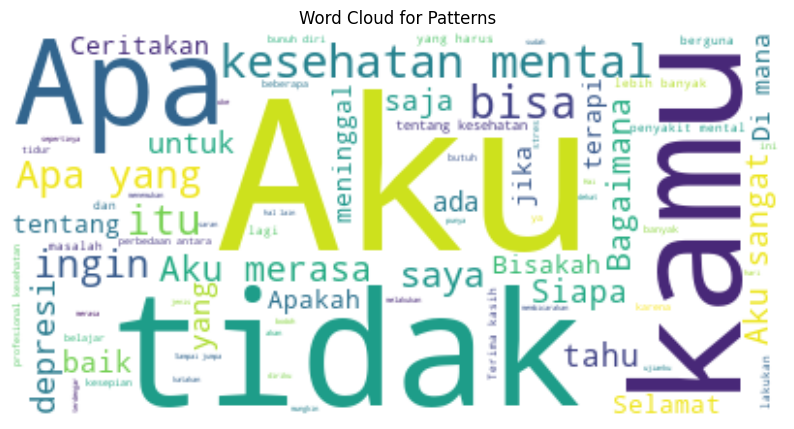

In [182]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(all_patterns)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Patterns')
plt.show()

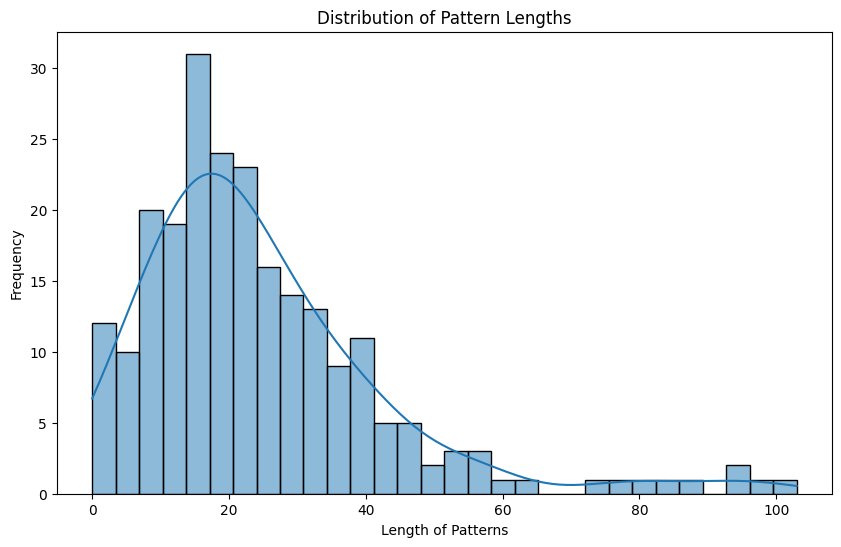

In [183]:
df['pattern_length'] = df['patterns'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['pattern_length'], bins=30, kde=True)
plt.title('Distribution of Pattern Lengths')
plt.xlabel('Length of Patterns')
plt.ylabel('Frequency')
plt.show()

In [184]:
import re

def preprocess_text(s):
    s = re.sub('[^a-zA-Z\']', ' ', s) 
    s = s.lower()
    s = s.split()
    s = " ".join(s)
    return s

df['patterns'] = df['patterns'].apply(preprocess_text)
df['tag'] = df['tag'].apply(preprocess_text)
df

,tag,patterns,responses,pattern_length
0,greeting,hai,[Halo. Ceritakan bagaimana perasaanmu hari ini...,3
1,greeting,hei,[Halo. Ceritakan bagaimana perasaanmu hari ini...,3
2,greeting,ada orang di sana,[Halo. Ceritakan bagaimana perasaanmu hari ini...,18
3,greeting,hai,[Halo. Ceritakan bagaimana perasaanmu hari ini...,3
4,greeting,halo,[Halo. Ceritakan bagaimana perasaanmu hari ini...,4
...,...,...,...,...
226,fact,bagaimana saya tahu jika saya sedang tidak sehat,"[Jika keyakinan, pikiran, perasaan, atau peril...",49
227,fact,bagaimana saya bisa menjaga koneksi sosial bag...,"[Banyak orang merasa sendirian sekarang, tetap...",80
228,fact,apa perbedaan antara kecemasan dan stres,[Stres dan kecemasan sering digunakan secara b...,41
229,fact,apa perbedaan antara kesedihan dan depresi,[Kesedihan adalah reaksi normal terhadap kehil...,43


In [185]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no response', 'neutral response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate you',
       'hate me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something else', 'friends', 'ask', 'problem',
       'no approach', 'learn more', 'user agree', 'meditation',
       'user meditation', 'pandora useful', 'user advice',
       'learn mental health', 'mental health fact', 'fact'], dtype=object)

In [186]:
len(df['tag'].unique())

50

In [187]:
X = df['patterns']
y = df['tag']

In [188]:
y

0      greeting
1      greeting
2      greeting
3      greeting
4      greeting
         ...   
226        fact
227        fact
228        fact
229        fact
230        fact
Name: tag, Length: 231, dtype: object

# PRE PROCESSING INDO

In [189]:
import numpy as np
import pandas as pd
import nltk
import random
import json
import re
import string
import itertools

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [190]:
import nltk
nltk.download('punkt')

nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [191]:
import json
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 1. Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# 2. Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 3. Load your intents.json
with open("intents.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 4. Flatten data
rows = []
for intent in data["intents"]:
    tag = intent["tag"]
    patterns = intent["patterns"]
    responses = intent["responses"]

    for pattern in patterns:
        for response in responses:
            rows.append({
                "intent": tag,
                "pattern": pattern,
                "response": response
            })

df = pd.DataFrame(rows)

# 5. Text preprocessing function
def preprocess_text(text):
    text = text.lower()                            # lowercase
    text = re.sub(r"[^\w\s]", " ", text)           # remove punctuation
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    text = ' '.join(words)
    stemmed = stemmer.stem(text)                   # stemming
    return stemmed.strip()

# 6. Apply preprocessing
df["pattern_clean"] = df["pattern"].apply(preprocess_text)
df["response_clean"] = df["response"].apply(preprocess_text)

# 7. Show result
print(df[["intent", "pattern", "pattern_clean", "response_clean"]].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     intent pattern pattern_clean           response_clean
0  greeting     Hai           hai          halo cerita asa
1  greeting     Hai           hai                 hai bawa
2  greeting     Hai           hai                  hai asa
3  greeting     Hai           hai         senang lihat asa
4  greeting     Hai           hai  halo senang lihat dunia


# Build Model

In [192]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [193]:
# Tokenization and Encoding the Data
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
max_len = 128 

def encode_texts(texts, max_len):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',      
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ALMIRA\.cache\huggingface\hub\models--indolem--indobert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [194]:
# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_labels = len(np.unique(y_encoded))

# Encode the patterns
input_ids, attention_masks = encode_texts(X, max_len)
labels = torch.tensor(y_encoded)

# Splitting the dataset into training and validation
dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_dataloader = DataLoader(val_dataset, batch_size=16)

# Model and Optimization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [195]:
# training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.2f}")

Epoch 1, Average Training Loss: 3.86
Epoch 2, Average Training Loss: 3.70
Epoch 3, Average Training Loss: 3.57
Epoch 4, Average Training Loss: 3.46
Epoch 5, Average Training Loss: 3.35
Epoch 6, Average Training Loss: 3.26
Epoch 7, Average Training Loss: 3.09
Epoch 8, Average Training Loss: 2.94
Epoch 9, Average Training Loss: 2.82
Epoch 10, Average Training Loss: 2.69


# Model Evaluation